# Section 1 – Data exploration and pre-processing

Load the dataset:

In [1]:
!pip install pyarrow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates # to format dates on plots
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_parquet('ssh_attacks.parquet')
df

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,enable ; system ; shell ; sh ; cat /proc/mount...,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,cat /proc/cpuinfo | grep name | wc -l ; echo -...,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [2]:
all_words = df["full_session"].explode()
df_most_common_words = all_words.value_counts().head(10)
most_common_word = df_most_common_words.idxmax()
frequency = df_most_common_words.max()
word_freq=df_most_common_words.to_dict()
print(f"The most  common word is: {most_common_word}")

The most  common word is: enable ; system ; shell ; sh ; cat /proc/mounts ; /bin/busybox SAEMW ; cd /dev/shm ; cat .s || cp /bin/echo .s ; /bin/busybox SAEMW ; tftp ; wget ; /bin/busybox SAEMW ; dd bs=52 count=1 if=.s || cat .s || while read i ; do echo $i ; done < .s ; /bin/busybox SAEMW ; rm .s ; exit ;


### 1.1 Temporal Series:

Monthly distribution of attacks:

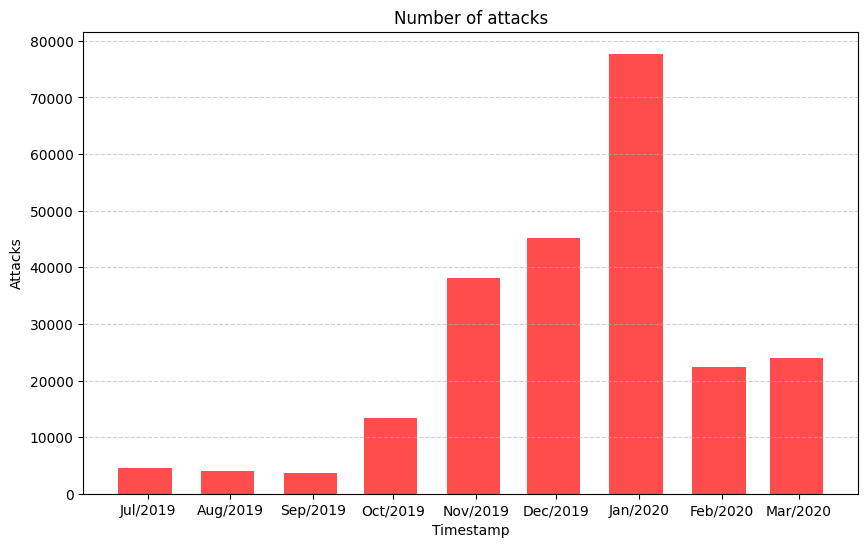

In [3]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])
df_copy.set_index('first_timestamp', inplace=True)
df_result = df_copy.resample('ME').size().reset_index(name='count')
df_result

plt.figure(figsize=(10, 6))
# for each month, count the number of rows, that are the number of packets
plt.bar(df_result['first_timestamp'], df_result['count'], alpha=0.7, width=20, color='r')
# Format x-axis to show month/year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Timestamp')
plt.ylabel('Attacks')
plt.title(f'Number of attacks')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Daily distribution of attacks:

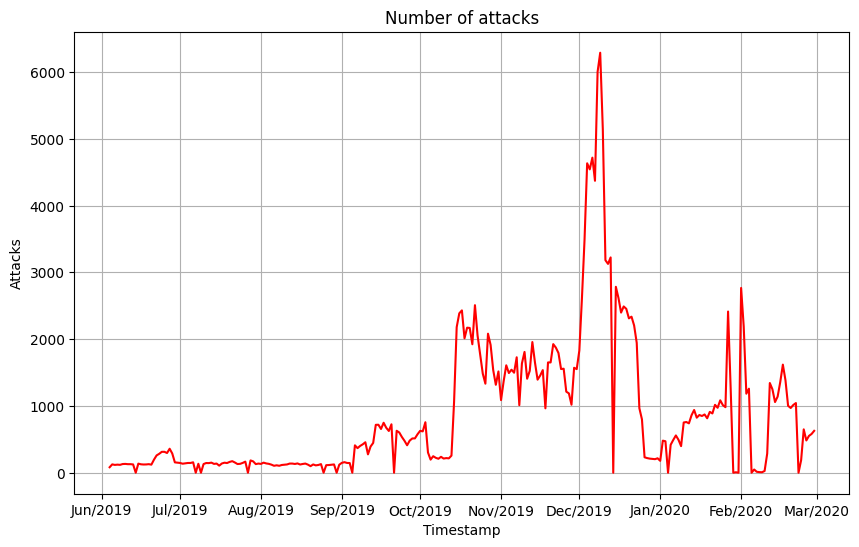

In [4]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])
df_copy.set_index('first_timestamp', inplace=True)
df_daily = df_copy.resample('D').size().reset_index(name='count')
df_daily

plt.figure(figsize=(10, 6))
# for each day, count the number of rows, that are the number of packets
plt.plot(df_daily['first_timestamp'], df_daily['count'], linestyle='-', color='r')
# Format x-axis to show month/year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.xlabel('Timestamp')
plt.ylabel('Attacks')
plt.title(f'Number of attacks')
plt.grid()
plt.show()

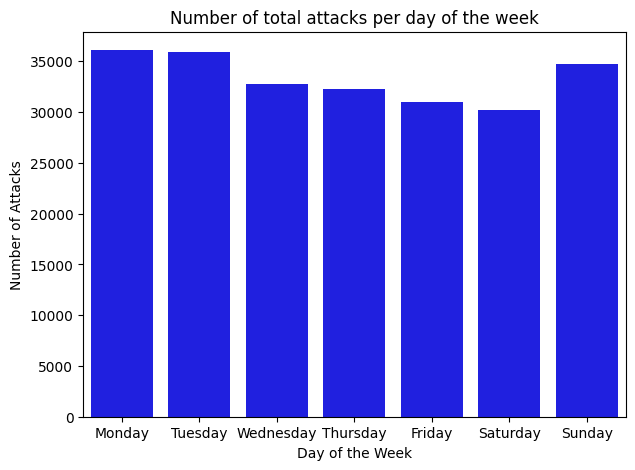

,day_name,count
0,Monday,36106
1,Tuesday,35911
2,Wednesday,32756
3,Thursday,32241
4,Friday,31017
5,Saturday,30238
6,Sunday,34766


In [5]:
df_copy = df.copy()
df_copy['first_timestamp'] = pd.to_datetime(df_copy['first_timestamp'])

# Extract the day of the week (0=Monday, 6=Sunday)
df_copy['day_of_week'] = df_copy['first_timestamp'].dt.dayofweek  # Numeric representation
df_copy['day_name'] = df_copy['first_timestamp'].dt.day_name()   # Full name of the day

# Group by day of the week and count occurrences
df_grouped = df_copy.groupby('day_name').size().reset_index(name='count')

# Ensure the days are ordered from Monday to Sunday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_grouped['day_name'] = pd.Categorical(df_grouped['day_name'], categories=day_order, ordered=True)
df_grouped = df_grouped.sort_values('day_name').reset_index(drop=True)

plt.figure(figsize=(7,5))
sns.barplot(
    data = df_grouped,
    x = "day_name",
    y = "count",
    color = 'blue'
)

plt.ylabel("Number of Attacks")
plt.xlabel("Day of the Week")
plt.title("Number of total attacks per day of the week")
plt.show()

df_grouped


### 1.2 empirical distribution

In [6]:
n_words = df['full_session'].apply(lambda session: len(session))
n_characters = df['full_session'].apply(lambda session: sum([len(word) for word in session]))
data = pd.DataFrame({"n_characters": n_characters, "n_words": n_words})
data

,n_characters,n_words
0,280,280
1,280,280
2,280,280
3,280,280
4,280,280
...,...,...
233030,608,608
233031,623,623
233032,623,623
233033,620,620


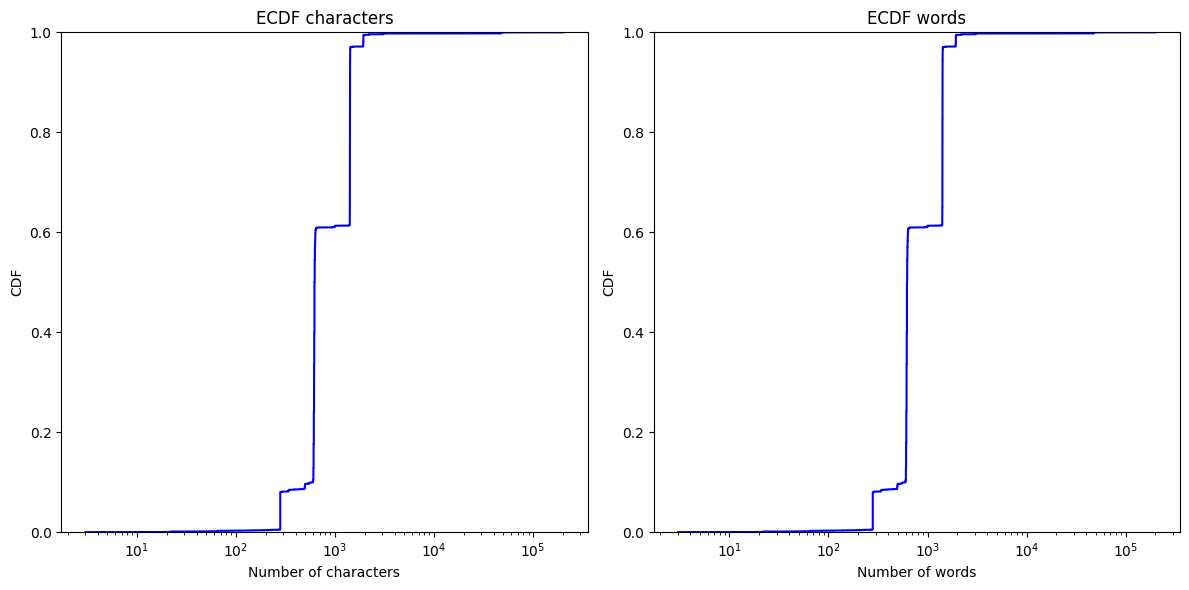

In [7]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.ecdfplot(
    data = data['n_characters'],
    log_scale=True,
    color = 'blue'
)
plt.title("ECDF characters")
plt.xlabel("Number of characters")
plt.ylabel("CDF")

plt.subplot(1,2,2)
sns.ecdfplot(
    data = data['n_words'],
    log_scale=True,
    color = 'blue'
)
plt.title("ECDF words")
plt.xlabel("Number of words")
plt.ylabel("CDF")

plt.tight_layout()
plt.show()

### 1.3 Common words in the sessions

In [8]:
import re

def split_words(command):
    strings = [part.strip() for part in re.split(r'[;|/.]\s*|\s+', command) if part.strip()] # split the string into a list
    # remove quoted text e.g. that can be a crypto key
    filtered_strings = [s for s in strings if not (s.startswith("'") and s.endswith("'")) and not (s.startswith('"') and s.endswith('"'))]
    
    return filtered_strings

# Define a function to filter out file paths and options
def filter_commands(command_list):
    filtered = []
    for cmd in command_list:
        # Exclude command options (strings starting with '-')
        if cmd.startswith("-"):
            continue
        if not cmd.isalpha():
            cmd = ''.join([i for i in cmd if i.isalpha()])  # Exclude everything that are not letters
        if not cmd: # check if empty string
            continue
        # Add to filtered list if it's a valid command
        filtered.append(cmd)
    return filtered

commands = df["full_session"] # double brackets to create a subset Dataframe instead of a Seires

commands = commands.apply(split_words)

# strip removes any leading and trailing spaces
# split regex:
# s*: Matches any amount of spaces after the symbols to allow for the possibility of spaces being next to the delimiter.
# s+: Matches one or more spaces in between words (acting as a delimiter between words or commands).

"""
The condition if part.strip() ensures that empty strings 
(which can occur if there are extra spaces or adjacent delimiters) 
are excluded from the resulting list.
"""
commands = commands.apply(filter_commands)

print(commands)


0         [enable, system, shell, sh, cat, proc, mounts,...
1         [enable, system, shell, sh, cat, proc, mounts,...
2         [enable, system, shell, sh, cat, proc, mounts,...
3         [enable, system, shell, sh, cat, proc, mounts,...
4         [enable, system, shell, sh, cat, proc, mounts,...
                                ...                        
233030    [cat, proc, cpuinfo, grep, name, wc, echo, pas...
233031    [cat, proc, cpuinfo, grep, name, wc, echo, pas...
233032    [cat, proc, cpuinfo, grep, name, wc, echo, pas...
233033    [cat, proc, cpuinfo, grep, name, wc, echo, pas...
233034    [cat, proc, cpuinfo, grep, name, wc, echo, pas...
Name: full_session, Length: 233035, dtype: object


In [9]:
# Flatten the Series into a single list
all_elements = [item for sublist in commands for item in sublist]

# Create a DataFrame with each element as a row
commands_df = pd.DataFrame({'Command': all_elements}).groupby('Command').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True).head(10)

print(commands_df)

   Command    count
0      var  1844567
1      tmp  1434358
2     grep  1278484
3      cat  1082838
4     echo   975339
5     proc   656669
6    uname   639142
7  cpuinfo   638869
8     name   638785
9       ls   518480


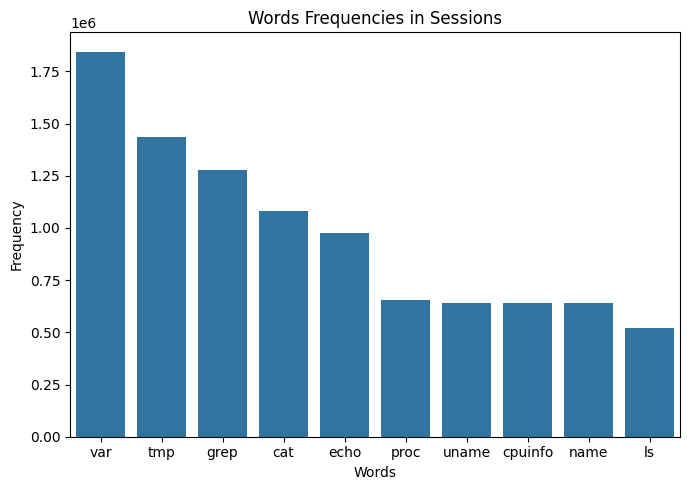

,Command,count
0,var,1844567
1,tmp,1434358
2,grep,1278484
3,cat,1082838
4,echo,975339
5,proc,656669
6,uname,639142
7,cpuinfo,638869
8,name,638785
9,ls,518480


In [10]:
plt.figure(figsize=(7,5))
sns.barplot(
    data = commands_df,
    x="Command",
    y="count"
)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Words Frequencies in Sessions")
plt.tight_layout()
plt.show()
commands_df

### 1.4 Distribution of Intents

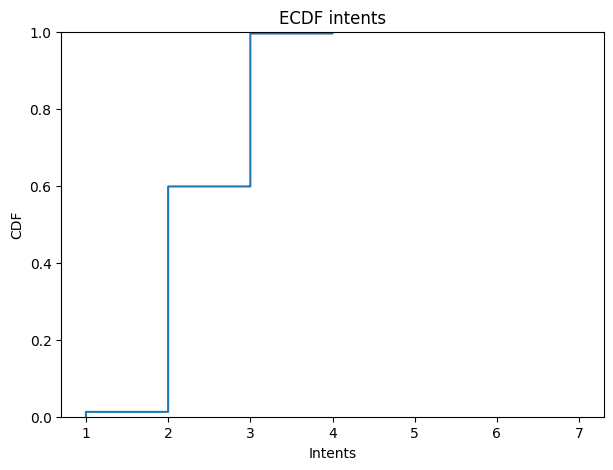

,session_id,first_timestamp,Set_Fingerprint
0,0,2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...
233030,233042,2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [11]:
df_intents = df[["session_id", "first_timestamp", "Set_Fingerprint"]]
# explode() is used to transform a list-like column in a DataFrame or Series into multiple rows, effectively "exploding" the list elements into separate rows.
df_intents_list = df_intents.explode('Set_Fingerprint')
intents = df_intents_list.groupby("session_id").size().to_frame("count")

plt.figure(figsize=(7,5))
sns.ecdfplot(
    data = intents,
    legend=False
)
plt.title("ECDF intents")
plt.xlabel("Intents")
plt.ylabel("CDF")
plt.show()
df_intents

Most common intents:

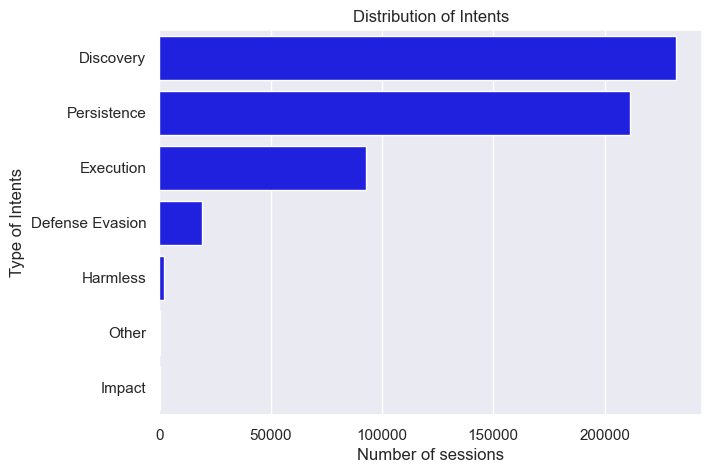

In [12]:
intents = df_intents_list.groupby('Set_Fingerprint').size().sort_values(ascending=False).to_frame("Number_of_sessions")

plt.figure(figsize=(7,5))
sns.set_theme(style="darkgrid")
sns.barplot(intents, x="Number_of_sessions", y=intents.index, color="blue", hue_order=intents.index)
plt.title('Distribution of Intents')
plt.xlabel('Number of sessions')
plt.ylabel('Type of Intents')

plt.show()

Distribution over tiime:

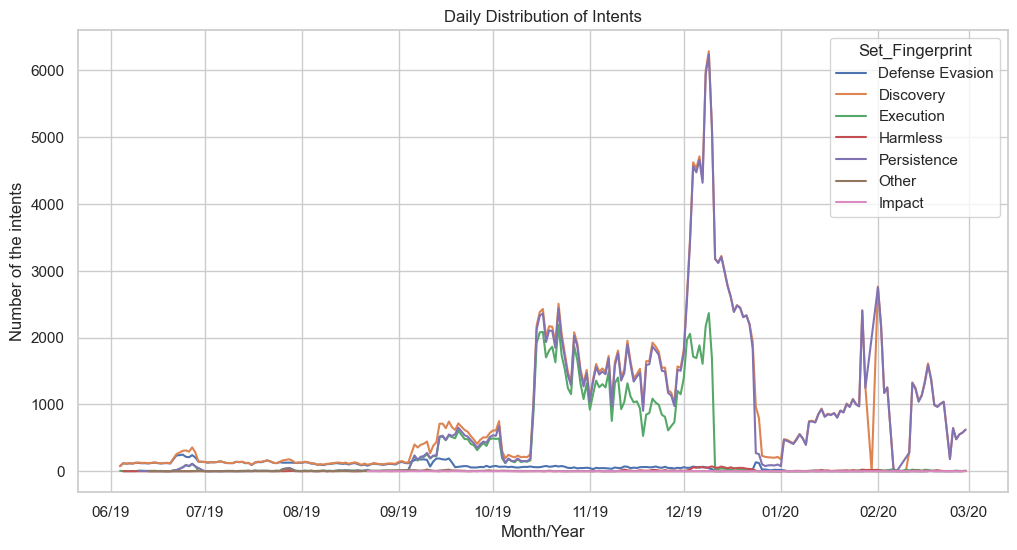

,first_timestamp,Set_Fingerprint,count
0,2019-06-04 00:00:00+00:00,Defense Evasion,80
1,2019-06-04 00:00:00+00:00,Discovery,75
2,2019-06-04 00:00:00+00:00,Execution,7
3,2019-06-05 00:00:00+00:00,Defense Evasion,120
4,2019-06-05 00:00:00+00:00,Discovery,122
...,...,...,...
1280,2020-02-29 00:00:00+00:00,Discovery,626
1281,2020-02-29 00:00:00+00:00,Execution,8
1282,2020-02-29 00:00:00+00:00,Harmless,7
1283,2020-02-29 00:00:00+00:00,Impact,1


In [13]:
df_intents_list['first_timestamp'] = pd.to_datetime(df_intents_list['first_timestamp'])
# A Grouper allows the user to specify a groupby instruction for an object.
distribution = df_intents_list.groupby([pd.Grouper(key='first_timestamp', freq='D'), 'Set_Fingerprint']).size().to_frame("count").reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(
    data = distribution,
    x = "first_timestamp",
    y = "count",
    hue="Set_Fingerprint",
    legend=True
)
plt.title("Daily Distribution of Intents")
plt.xlabel("Month/Year")
plt.ylabel("Number of the intents")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

plt.show()

plt.show()
distribution


### 1.5 WordCloud

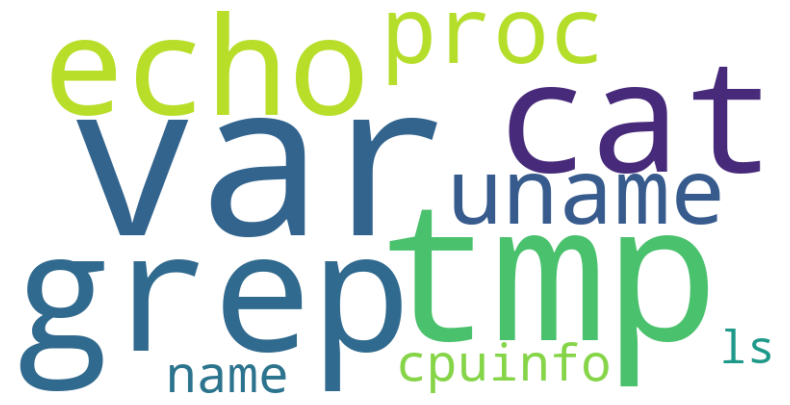

In [14]:
# Convert DataFrame to dictionary
word_freq = dict(zip(commands_df['Command'], commands_df['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 1.6 TF-IDF

In [ ]:
# commands is a df in which each row is a session and for each we have rhe list of words used
# Convert the list of words to a single string per session
words_per_session = commands.apply(lambda x: ' '.join(x))

# Initialize the TfidfVectorizer with a min_df threshold of 0.05
# The min_df parameter ensures that only words appearing in at least 5% of the sessions are included in the TF-IDF computation. 
# This filters out rare words.
tfidf_vectorizer = TfidfVectorizer(min_df=0.05)

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(words_per_session)

# Get feature names (words)
words = tfidf_vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=words)

# Add session IDs for reference
tfidf_df['session_id'] = words_per_session.index

# Reshape DataFrame to associate each word with its TF-IDF value in each session
tfidf_long_df = tfidf_df.melt(
    id_vars=["session_id"], 
    var_name="word", 
    value_name="tfidf_value"
)

# Filter out zero TF-IDF values and round values to the hundredth
tfidf_long_df = tfidf_long_df[tfidf_long_df['tfidf_value'] > 0].round(2)

# Display the result
tfidf_long_df.to_csv('tfidf.csv', index=False)
